In [1]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

MODEL_NAME = "unet"
IMG_MIN_SIZE = 128
IMG_CHANNELS = 3

STEPS_IN_TRAINING = 20
STEPS_IN_EVALUATION = None

# # Crippled version so that it can run as Kernel, comment that out and use the settings above.
# STEPS_IN_TRAINING=1
# STEPS_IN_EVALUATION=1

USE_WEIGHTS_N_EROSION = False

from pathlib import Path
# TRAIN_PATH = Path('D:\\UNET in Tensorflow\\Unet_Tensor\\dataset\\training')
TRAIN_PATH = Path('D:\\UNET in Tensorflow\\Unet_Tensor\\datasets')
TEST_PATH = Path('D:\\UNET in Tensorflow\\Unet_Tensor\\dataset\\testing')

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
%matplotlib inline  
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io, transform, morphology, filters
from scipy import ndimage
import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [4]:
from collections import namedtuple
import hashlib 
#Instead of relying on random seeds to keep validation set separate from training
#Using SHA1 to convert a file name to a random number between 1 and 100.
def filename_to_uniform_number(filepath, MAX_ITEMS_PER_CLASS=2 ** 27 - 1 ):
    """Associate the `filepath` to a number [0.0 - 1.0] based on file name.
        
    The numbers are generated based on sha1 of the file name, so should be uniformly distributed 
    and can be used to separate a validation set from training set. It let's you later add more training examples
    and keep the training and validation set separate.

    Parameters
    ----------
          filepath - pathlib.Path object with a path to file name
          MAX_ITEMS_PER_CLASS - helper constant defining a maximum number elements in class
    Returns
    -------
          a number random number from 0.0-1.0 to upper_bound, that depends only on a file name
    """
    hash_name = filepath.name.split('_nohash_')[0]
    hash_name_hashed = hashlib.sha1(hash_name.encode("utf-8")).hexdigest()
    return ((int(hash_name_hashed, 16) % (MAX_ITEMS_PER_CLASS + 1)) *
           (1 / MAX_ITEMS_PER_CLASS))

def which_set(fn, validation_size=0.10):
    if filename_to_uniform_number(fn) < validation_size:
         return tf.estimator.ModeKeys.EVAL
    return tf.estimator.ModeKeys.TRAIN

In [5]:
TE = namedtuple('TE', [tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL])
paths = TE([],[])
for x in TRAIN_PATH.glob("*"):
    getattr(paths, which_set(x, 0.16666)).append(x)

print("Validation set precentage:", len(paths.eval)/(len(paths.train)+len(paths.eval)))


Validation set precentage: 0.16695285764738835


In [6]:
# print(paths)

In [7]:
IMG = (slice(None), slice(None), slice(0,3))
MASK = (slice(None), slice(None), slice(3,4))
WEIGHTS = (slice(None), slice(None), slice(4,5))

In [8]:
# print(IMG)
# print(MASK)
# print(WEIGHTS)

In [9]:
def show_sample(sample):   
    if type (sample) == tf.Tensor:
        print("Unable to display tensor that was not executed, run_in_sess(sample)", sample)
        return
    images = [sample[IMG], sample[MASK], sample[WEIGHTS]]
    show_image_list(images)

def show_image_list(images):
    if len(images) == 1:
        im = plt.imshow(np.squeeze(images[0]))
    else:
        fig, axs = plt.subplots(1, len(images), figsize=(20,20))
        for img, ax in zip(images, axs):
            im = ax.imshow(np.squeeze(img))
        fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.2)
    plt.show()

In [10]:
def calculate_unet_background_weight(merged_mask, masks, w0=10, q=5,):
    weight = np.zeros(merged_mask.shape)
    # calculate weight for important pixels
    distances = np.array([ndimage.distance_transform_edt(m==0) for m in masks])
    shortest_dist = np.sort(distances, axis=0)
    # distance to the border of the nearest cell 
    d1 = shortest_dist[0]
    # distance to the border of the second nearest cell
    d2 = shortest_dist[1] if len(shortest_dist) > 1 else np.zeros(d1.shape)

    weight = w0 * np.exp(-(d1+d2)**2/(2*q**2)).astype(np.float32)
    weight = 1 + (merged_mask == 0) * weight
    return weight

def binary_erosion_tf(mask):
    def binary_erosion(img):
        img = ndimage.morphology.binary_erosion((img > 0 ), border_value=1).astype(np.uint8)
        return img
    return tf.py_func(binary_erosion, [mask], tf.uint8)

def calculate_weights_tf(merged_mask, masks):
    return tf.py_func(calculate_unet_background_weight, [merged_mask, masks], tf.float32)

A slow version of load_sample that calculate weights and erosion, normally the weigts are set to an array of ones
Sample size: (128, 128, 5)


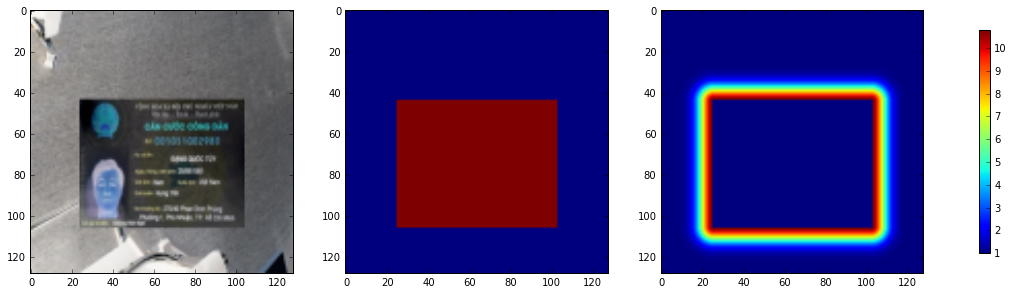

Maximum weight set 10.801987


In [11]:
def load_mask_tf(sample_path, use_weights_n_erosion=USE_WEIGHTS_N_EROSION):
    mask_ds = (tf.data.Dataset.list_files(sample_path+"/masks*/*.png")
                .map(lambda x: tf.image.decode_image(tf.read_file(x), channels=1), num_parallel_calls=4))
    
    if use_weights_n_erosion:
        mask_ds = mask_ds.map(binary_erosion_tf)

    masks = tf.contrib.data.get_single_element(mask_ds.batch(1024))
    masks = tf.clip_by_value(tf.cast(masks, dtype=tf.float32), 0, 1) # convert to binary mask (it was 0, 255)
    colors = tf.cast(tf.range(1, tf.shape(masks)[0]+1), dtype=tf.float32)
    colors = tf.reshape(colors, shape=[-1,1,1,1])
    merged_mask = tf.reduce_max(masks * colors, axis=0)
    
    if use_weights_n_erosion:
        weights = calculate_weights_tf(merged_mask, masks)
    else:
        weights = tf.ones_like(merged_mask)
        
    return merged_mask, weights

def load_sample_tf(sample_path, load_mask=True, use_weights_n_erosion=USE_WEIGHTS_N_EROSION):  
    image = tf.contrib.data.get_single_element(tf.data.Dataset.list_files(sample_path+"/images/*.png")
            .map(lambda x: tf.image.decode_image(tf.read_file(x), channels=3)))
    image = tf.cast(image, dtype=tf.float32)  
    if load_mask:
        merged_mask, weights = load_mask_tf(sample_path, use_weights_n_erosion=use_weights_n_erosion)
        sample = tf.concat([image, merged_mask, weights], axis=2)
    else:
        img_shape = tf.shape(image)
        mask_shape = [img_shape[0],img_shape[1],1]
        sample = tf.concat([image, tf.zeros(mask_shape), tf.ones(mask_shape)], axis=2)

    return sample

def run_in_sess(fn, *args, **kwargs):
    with tf.Graph().as_default():
        x = fn(*args, **kwargs)
        init = (tf.global_variables_initializer(), tf.local_variables_initializer())
        with tf.Session() as sess:
            sess.run(init)
            ret = sess.run(x)
    return ret

def load_sample(sample_path, load_mask=True, use_weights_n_erosion=USE_WEIGHTS_N_EROSION):
    return run_in_sess(load_sample_tf, str(sample_path), load_mask, use_weights_n_erosion)

sample = load_sample(paths.train[350], use_weights_n_erosion=True)
print("A slow version of load_sample that calculate weights and erosion, normally the weigts are set to an array of ones")
print("Sample size:", sample.shape)
show_sample(sample)
assert sample.dtype == 'float32'
assert sample.shape[2] == 5, sample.shape[2]
print("Maximum weight set", np.max(sample[WEIGHTS]))

In [12]:
# sample_path = "D:\\UNET in Tensorflow\\Unet_Tensor\\datasets\\abp00000"
# a, b = load_mask_tf(sample_path, use_weights_n_erosion=USE_WEIGHTS_N_EROSION)
# print(a,b)

Orignal shape: (128, 128, 5) new padded shape: (128, 128, 5)


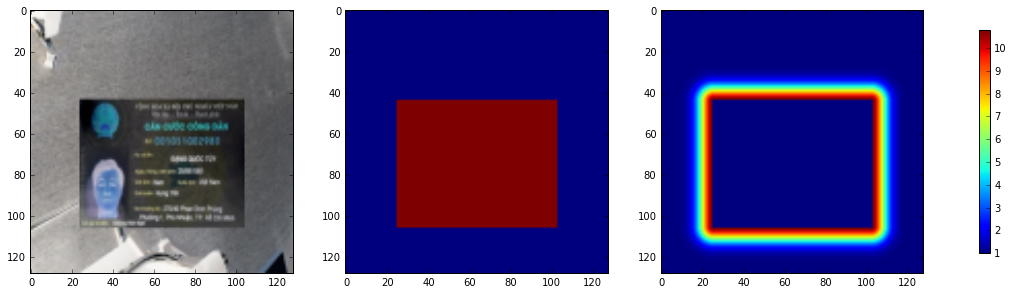

In [13]:
def pad_to_min_size_tf(img, batch=False):
    """Pads image so that it's height and width is divisable by IMG_MIN_SIZE
    
    It handles both single images or batches of images.
    """
    if batch:
        print ("Batch mode")
        img_shape=slice(1,3)
        samples_dim = [[0,0]]
    else:
        img_shape=slice(0,2)
        samples_dim = []
        
    shape = tf.shape(img)    
    desired_shape = tf.cast(tf.ceil(tf.cast(shape[img_shape], dtype=tf.float32) / IMG_MIN_SIZE) * IMG_MIN_SIZE, dtype=tf.int32)
    pad = (desired_shape - shape[img_shape]) 
    padding = samples_dim+[[0, pad[0]], [0, pad[1]], [0, 0]]
    return tf.pad(img, padding, mode='SYMMETRIC', name='test'), shape

#sample2, orig_shape = run_in_sess(pad_to_min_size_tf, np.expand_dims(sample,0), batch=False)
sample2, orig_shape = run_in_sess(pad_to_min_size_tf, sample, batch=False)
print("Orignal shape:", sample.shape, "new padded shape:", sample2.shape)
show_sample(sample2)

Croping (128, 128, 3) to (128, 128, 3)
Orignal


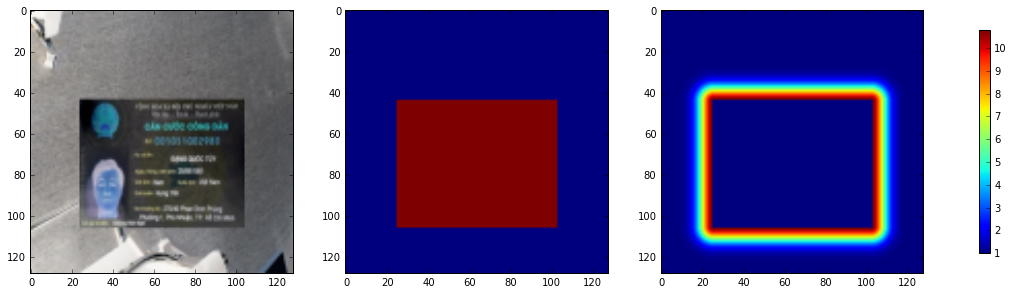

Cropped version


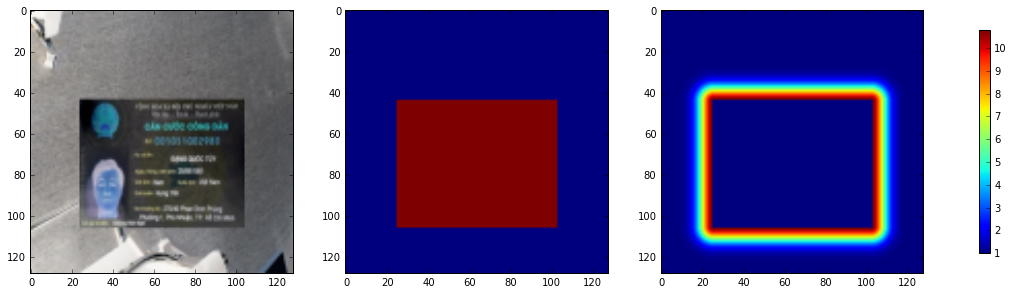

In [14]:
def random_crop_tf(sample):
    return tf.random_crop(sample, size=[IMG_MIN_SIZE, IMG_MIN_SIZE, tf.shape(sample)[2]])

sample2 = run_in_sess(random_crop_tf, sample)
print("Croping", sample[IMG].shape, "to", sample2[IMG].shape)
print("Orignal")
show_sample(sample)
print("Cropped version")
show_sample(sample2)

3 first samples extracted from the large sample (128, 128, 5)
Total amount of samples extracted: 1


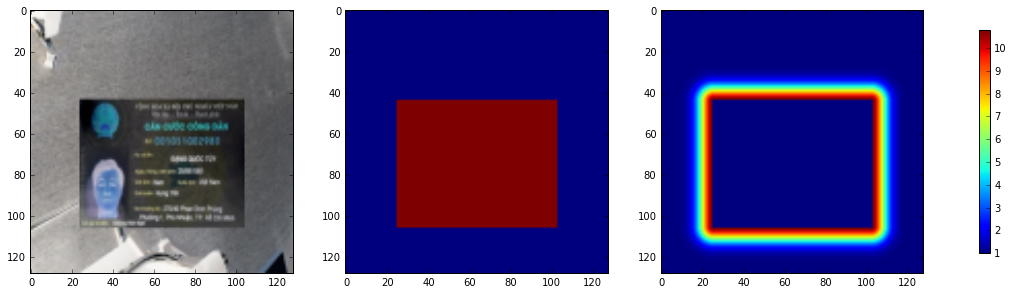

In [15]:
def cut_to_many_tf(sample, return_dataset=True):
    """Cut a padded sample to many images of size IMG_MIN_SIZExIMG_MIN_SIZE.
    
    Used for validation set where we don't want to use random_crop.
    """
    even_sample, orig_size = pad_to_min_size_tf(sample)
    shape = tf.shape(even_sample)
    
    ch = shape[2]
    y = shape[1]
    split_y = tf.reshape(even_sample, [-1, IMG_MIN_SIZE, y, ch])
    split_num = tf.cast(tf.shape(even_sample)[0]//IMG_MIN_SIZE, dtype=tf.int64)

    def split_in_x(i):

        y0 = tf.cast(i*IMG_MIN_SIZE, dtype=tf.int32)
        y1 = tf.cast((i+1)*IMG_MIN_SIZE, dtype=tf.int32)
        
        img = split_y[:, :, y0:y1, :]
        return tf.data.Dataset.from_tensor_slices(img)
    
    ds = tf.data.Dataset.range(split_num).flat_map(split_in_x)
    if return_dataset:
        return ds
    return tf.contrib.data.get_single_element(ds.batch(1024))


new_samples = run_in_sess(cut_to_many_tf, sample, False)
print("3 first samples extracted from the large sample", sample.shape)
print("Total amount of samples extracted:",len(new_samples))
for s in new_samples[:3]:
    show_sample(s)

In [16]:
img_test = "D:\\UNET in Tensorflow\\Unet_Tensor\\dataset\\image_test\\PNG\\1_cv.png"

In [27]:
def input_fn(sample_paths, batch_size=1, shuffle=True, num_epochs=1, take=None, load_labels=True):
    """Reads all samples form a sample_paths list, then tranforms them so that it can be used in training.
    
    Parameters
    ----------
        sample_paths - list of string or pathlib.Path objects pointing to directories with samples
        batch_size   - size of a single batch
        shuffle      - if True shuffles the order of samples _and_ use `random_crop_tf` to crop images to IMG_MIN_SIZExIMG_MIN_SIZE
                       else it uses `cut_to_man_tf` which cut's large images to images matching our required size.
        num_epochs   - if None it will iterate over the dataset forever, otherwise it returns that number of epochs. 
                       Make sure you don't set it to None for your evaluation set. 
        take         - returns 'take' amount of batches
        load_labels  - can be set to False if you load the test data set using this function
    
    Returns
    -------
        input_fn to be used with `estimator.train` or `.evaluate`
    """
    
    # Estimator API except a different representation of samples, as tuple of dicts one for features one for labels.
    # so we have this small conversion utility
    def sample_to_features_n_labels(sample): 
        """Conver our sample representation to match tensorflow API
        """
        return {'image':sample[IMG]}, {'mask': sample[MASK], 'weights': sample[WEIGHTS]}
    
    sample_paths_tensor = tf.constant(list(map(str, sample_paths)), dtype=tf.string)
    
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices(sample_paths_tensor)

        # As you see Dataset.shuffle except a buffer that can hold all samples to correctly shuffle them.
        # Since we are starting from paths the buffer does not have to be that large.
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(sample_paths))
 
        while(1):
            try:
                
                dataset = (dataset
                    .map(lambda x: load_sample_tf(x, load_mask=load_labels), num_parallel_calls=4)
                    .cache()) # this does not work that well if the evaluation is being done on the same GPU as training.
                print(dataset)
            except tf.errors.OutOfRangeError() as e:
                print(e)
                pass
#         dataset = (dataset
#             .map(lambda x: load_sample_tf(x, load_mask=load_labels), num_parallel_calls=4)
#             .cache()) # this does not work that well if the evaluation is being done on the same GPU as training.

        if shuffle:
            dataset = dataset.map(random_crop_tf)
        else:
            dataset = dataset.flat_map(cut_to_many_tf)            

        dataset = (dataset.map(sample_to_features_n_labels)
            .repeat(num_epochs)
            .batch(batch_size)
            .prefetch(1)
        )

        if take is not None:
            dataset = dataset.take(take)
            
        iterator = dataset.make_one_shot_iterator()
        # `features` is a dictionary in which each value is a batch of values for
        # that feature; `labels` is a batch of labels.
        features, labels = iterator.get_next()
        return features, labels
    return input_fn

import time
start_time = time.time()

with tf.Graph().as_default():
    it = input_fn(paths.eval, batch_size=1024)()
    with tf.Session() as s:    
        all_eval_samples = (s.run((it)))
        print("First batch fetched, now the ds should stop")
        try:
            nothing = (s.run((it)))
        except tf.errors.OutOfRangeError:
            print("The iterator correctly let us know that it is empty.")
    
images_loaded = all_eval_samples[0]['image'].shape[0]
total_time = (time.time() - start_time)
print("Total execution time %s sec, performance %s samples / sec" % (total_time, images_loaded/total_time))

<CacheDataset shapes: <unknown>, types: tf.float32>


TypeError: __init__() missing 3 required positional arguments: 'node_def', 'op', and 'message'

In [25]:
input_fn(paths.train,  batch_size=128, shuffle=False, num_epochs=None)
print(input_fn)

<function input_fn at 0x0000018CF405A048>


In [20]:
# def input_fn(sample_paths, batch_size=1, shuffle=False, num_epochs=1, take=None, load_labels=True):
#     """Reads all samples form a sample_paths list, then tranforms them so that it can be used in training.
    
#     Parameters
#     ----------
#         sample_paths - list of string or pathlib.Path objects pointing to directories with samples
#         batch_size   - size of a single batch
#         shuffle      - if True shuffles the order of samples _and_ use `random_crop_tf` to crop images to IMG_MIN_SIZExIMG_MIN_SIZE
#                        else it uses `cut_to_man_tf` which cut's large images to images matching our required size.
#         num_epochs   - if None it will iterate over the dataset forever, otherwise it returns that number of epochs. 
#                        Make sure you don't set it to None for your evaluation set. 
#         take         - returns 'take' amount of batches
#         load_labels  - can be set to False if you load the test data set using this function
    
#     Returns
#     -------
#         input_fn to be used with `estimator.train` or `.evaluate`
#     """
    
#     # Estimator API except a different representation of samples, as tuple of dicts one for features one for labels.
#     # so we have this small conversion utility
#     def sample_to_features_n_labels(sample): 
#         """Conver our sample representation to match tensorflow API
#         """
#         return {'image':sample[IMG]}, {'mask': sample[MASK], 'weights': sample[WEIGHTS]}
    
#     sample_paths_tensor = tf.constant(list(map(str, sample_paths)), dtype=tf.string)
# #     print(sample_paths_tensor)
#     dataset = tf.data.Dataset.from_tensor_slices(sample_paths_tensor)
# #     print(dataset)
    
#     def input_fn():
#         dataset = tf.data.Dataset.from_tensor_slices(sample_paths_tensor)
        
# #         var(dataset)

#         As you see Dataset.shuffle except a buffer that can hold all samples to correctly shuffle them.
#         Since we are starting from paths the buffer does not have to be that large.
#         if shuffle:
#             dataset = dataset.shuffle(buffer_size=len(sample_paths))
# #         print("data:",dataset)
        
# #         while(1):
# #             try:
                
# #                 dataset = (dataset
# #                     .map(lambda x: load_sample_tf(x, load_mask=load_labels), num_parallel_calls=4)
# #                     .cache()) # this does not work that well if the evaluation is being done on the same GPU as training.
# #                 print(dataset)
# #             except tf.errors.OutOfRangeError() as e:
# #                 print(e)
# #                 pass
 


#         if shuffle:
#             dataset = dataset.map(random_crop_tf)
#         else:
#             dataset = dataset.flat_map(cut_to_many_tf)            
# #         print(dataset)
#         dataset = (dataset.map(sample_to_features_n_labels)
#             .repeat(num_epochs)
#             .batch(batch_size)
#             .prefetch(1)
#         )
        
#         print(dataset)
#         if take is not None:
#             dataset = dataset.take(take)
            
#         print(dataset)
#         iterator = dataset.make_one_shot_iterator()
#         # `features` is a dictionary in which each value is a batch of values for
#         # that feature; `labels` is a batch of labels.
#         features, labels = iterator.get_next()
# #         print(dataset)
#         return features, labels
#     return input_fn

# import time
# start_time = time.time()

# with tf.Graph().as_default():
#     it = input_fn(paths.eval, batch_size=1024)()
#     with tf.Session() as s:    
#         all_eval_samples = (s.run((it)))
#         print("First batch fetched, now the ds should stop")
#         try:
#             nothing = (s.run((it)))
#         except tf.errors.OutOfRangeError:
#             print("The iterator correctly let us know that it is empty.")
    
# images_loaded = all_eval_samples[0]['image'].shape[0]
# total_time = (time.time() - start_time)
# print("Total execution time %s sec, performance %s samples / sec" % (total_time, images_loaded/total_time))

SyntaxError: invalid syntax (<ipython-input-20-550d035213b8>, line 37)

In [ ]:
input_fn(paths.train, batch_size=128, shuffle=False, num_epochs=None)

In [ ]:
def show_features_n_labels(features, labels, max_samples=1):
    features = np.array([i for i in features.values()]) 
    labels = np.array([i for i in labels.values()])

    if len(features.shape) not in [4,5]:
        raise AttributeError("Wrong shape of images", features.shape)

    if len(features.shape) == 4:
        features = np.expand_dims(features)
        labels = np.expand_dims(labels)

    ## TODO: make it more efficient at trimming the batch
    samples_to_show = min(max_samples, features.shape[1])        
    for sample_idx in range(0, samples_to_show):
        sample = [f for f in features[:,sample_idx,:,:,:]] + [l for l in labels[:,sample_idx,:,:,:]]
        show_image_list(sample)
    
show_features_n_labels(*all_eval_samples, max_samples=2)

In [ ]:
from tensorflow.python.ops import array_ops

def conv2d_3x3(filters):
    return tf.layers.Conv2D(filters, kernel_size=(3,3), activation=tf.nn.relu, padding='same')

def max_pool():
    return tf.layers.MaxPooling2D((2,2), strides=2, padding='same') 

def conv2d_transpose_2x2(filters):
    return tf.layers.Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding='same')

def concatenate(branches):
    return array_ops.concat(branches, 3)

def get_model(features, mode, params):
    x = features['image']
    x = tf.placeholder_with_default(x, [None, None, None, IMG_CHANNELS], name='input_image_placeholder')
    
    s = x / 255 # convert image to 0 .. 1.0

    c1 = conv2d_3x3(8) (s)
    c1 = conv2d_3x3(8) (c1)
    p1 = max_pool() (c1)

    c2 = conv2d_3x3(16) (p1)
    c2 = conv2d_3x3(16) (c2)
    p2 = max_pool() (c2)

    c3 = conv2d_3x3(32) (p2)
    c3 = conv2d_3x3(32) (c3)
    p3 = max_pool() (c3)

    c4 = conv2d_3x3(64) (p3)
    c4 = conv2d_3x3(64) (c4)
    p4 = max_pool() (c4)

    c5 = conv2d_3x3(128) (p4)
    c5 = conv2d_3x3(128) (c5)

    u6 = conv2d_transpose_2x2(64) (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_3x3(64) (u6)
    c6 = conv2d_3x3(64) (c6)

    u7 = conv2d_transpose_2x2(32) (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_3x3(32) (u7)
    c7 = conv2d_3x3(32) (c7)

    u8 = conv2d_transpose_2x2(16) (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_3x3(16) (u8)
    c8 = conv2d_3x3(16) (c8)

    u9 = conv2d_transpose_2x2(8) (c8)
    u9 = concatenate([u9, c1])
    c9 = conv2d_3x3(8) (u9)
    c9 = conv2d_3x3(8) (c9)

    logits = tf.layers.Conv2D(1, (1, 1)) (c9)
    return logits

In [ ]:
def model_fn(features, labels, mode, params={}):
    if mode == tf.estimator.ModeKeys.PREDICT:
        f, sh = pad_to_min_size_tf(features['image'], batch=True)
        logits = get_model({'image': f}, mode, params)

        mask = tf.nn.sigmoid(logits, name='sigmoid_tensor')        
        predictions = {
            'mask': mask[:,0:sh[1],0:sh[2],:], # we remove pixels added in pad_to_min_size_tf
            'image': features['image']         # we return the image as well to simplify testing
        }
    
        export_outputs={'generate' : tf.estimator.export.PredictOutput(predictions)}
        return tf.estimator.EstimatorSpec(mode=mode, 
                                          predictions=predictions,
                                          export_outputs=export_outputs)
    logits = get_model(features, mode, params)
    predictions = {
        'mask': tf.nn.sigmoid(logits, name='sigmoid_tensor'),
    }

    true_mask = tf.reshape(tf.clip_by_value(labels['mask'], 0.0 ,1.0), [-1, 128,128,1])
    weights = labels['weights']
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=true_mask, 
                                           logits=logits,
                                           weights=weights)

    # Configure the training op
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer =  tf.train.AdamOptimizer(learning_rate=1e-4)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, tf.train.get_or_create_global_step())

    else:
        train_op = None


    with tf.variable_scope('mean_iou_calc'):
        prec = []
        up_opts = []
        for t in np.arange(0.5, 1.0, 0.05):
            predicted_mask = tf.to_int32(predictions['mask'] > t)
            score, up_opt = tf.metrics.mean_iou(true_mask, predicted_mask, 2)
            up_opts.append(up_opt)
            prec.append(score)
        mean_iou = tf.reduce_mean(tf.stack(prec), axis=0), tf.stack(up_opts)

    eval_metrics = {'mean_iou': mean_iou}

    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metrics)

In [21]:
run_config = tf.estimator.RunConfig(keep_checkpoint_max=25)
estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    model_dir="./model_output/"+MODEL_NAME,
    config=run_config)

# In case you want to profile this model here is a profile hook. To use it add hooks=[profiler_hook] to TrainSpec.

# tf.gfile.MakeDirs('timelines/'+MODEL_NAME)
# profiler_hook = tf.train.ProfilerHook(
#     save_steps=1000,
#     save_secs=None,
#     output_dir='timelines/'+MODEL_NAME,
#     show_dataflow=True,
#     show_memory=True)

NameError: name 'model_fn' is not defined

In [ ]:
input_fns = TE(input_fn(paths.train, 
                           batch_size=128, 
                           shuffle=False, 
                           num_epochs=None),
               input_fn(paths.eval, batch_size=10, shuffle=False),)
specs = TE(tf.estimator.TrainSpec(input_fn=input_fns.train, max_steps=STEPS_IN_TRAINING),
          tf.estimator.EvalSpec(input_fn=input_fns.eval, steps=STEPS_IN_EVALUATION, throttle_secs=600))

tf.estimator.train_and_evaluate(estimator, specs.train, specs.eval)